In [149]:
import pandas as pd
import math
import numpy as np

# Load data
DATA_PATH = '../data/full_data_season.csv'
data = pd.read_csv(DATA_PATH, index_col=0)
  
# Drop Date, HomeTeam, AwayTeam
data.drop(columns=['Date','HomeTeam','AwayTeam'], inplace=True)
data.drop(columns=['FTHG','FTAG'], inplace=True)
    
# Dimension Tests (check how many points are lost with dropping NaNs from historical match data)
print(len(data)-len(data.dropna()))
d1 = data.drop(columns=['FTHG-3','FTAG-3','home_bool-3','result-3'])
print(len(d1)-len(d1.dropna()))
d2 = data.drop(columns=['FTHG-3','FTAG-3','home_bool-3','result-3','FTHG-2','FTAG-2','home_bool-2','result-2'])
print(len(d2)-len(d2.dropna()))


5100
3711
1859


In [150]:
# First of two tests: Drop -3 and -2 historical matches and then dropna (must be done before one-hot encoding)
# And drop unnecessary columns
# Alternatively, use weighted average value of -3,-2,-1 (TODO!!!) 
data.drop(columns=['FTHG-3','FTAG-3','home_bool-3','result-3','FTHG-2','FTAG-2','home_bool-2','result-2'], inplace=True)
data.drop(columns=['FTHG-1','FTAG-1'], inplace=True)
data.dropna(inplace=True)

#Use combined features (home-away stats) to see if they result in better correlations with label
home_stats = data.loc[:,:'home_oppda_ratio'].columns.values.tolist()
away_stats = data.loc[:,'away_xG':'away_oppda_ratio'].columns.values.tolist()
for home,away in zip(home_stats, away_stats):
    data['comb'+home[4:]] = data[home]-data[away]

In [151]:
#C reate train, test sets
from sklearn.model_selection import train_test_split #for random sampling

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)  #random sampling, 20% test data, seed 42 for repeatability

# Check sampling bias
data['result'].value_counts()
print('total class count:\n', data['result'].value_counts())
print('train set ratio:\n', train_set['result'].value_counts()/data['result'].value_counts())
print('test set ratio:\n', test_set['result'].value_counts()/data['result'].value_counts())


total class count:
 w    5070
l    3439
d    2842
Name: result, dtype: int64
train set ratio:
 w    0.803156
l    0.794708
d    0.800493
Name: result, dtype: float64
test set ratio:
 w    0.196844
l    0.205292
d    0.199507
Name: result, dtype: float64


In [152]:
# For Data inspection (can be removed later)
import matplotlib.pyplot as plt

# One-hot encode result of current match and previous ones, and drop unnecessary columns
data_inspect = pd.concat([train_set, pd.get_dummies(train_set['result'], prefix='result')], axis=1)
data_inspect.drop(columns=['result'], inplace=True)

match_list = [-1]  # Only -1 match left
for match in match_list:
    data_inspect = pd.concat([data_inspect, pd.get_dummies(data_inspect['result%d'%(match)], prefix='result%d'%(match))], axis=1)
    data_inspect.drop(columns=['result%d'%(match)], inplace=True)

corr_matrix = data_inspect.copy().corr()  #Compute standard correlation coefficient (Pearson's r)

print('For win:\n',corr_matrix['result_w'].sort_values(ascending=False))
print('For lose:\n',corr_matrix['result_l'].sort_values(ascending=False))
print('For draw:\n',corr_matrix['result_d'].sort_values(ascending=False))


For win:
 result_w             1.000000
comb_npxGD           0.320364
comb_xpts            0.315850
comb_npxG            0.305873
comb_xG              0.303869
comb_pts             0.293375
comb_wins            0.288176
comb_deep            0.280922
comb_oppda_ratio     0.273854
home_npxGD           0.230266
home_oppda_ratio     0.188558
home_wins            0.159472
home_deep            0.147417
home_pts             0.141784
away_loses           0.134726
home_npxG            0.131812
home_xG              0.127215
home_xpts            0.126514
away_ppda_ratio      0.097739
away_npxGA           0.094885
away_xGA             0.092424
away_deep_allowed    0.091976
result-1_l           0.054939
away_draws           0.038308
result-1_d           0.016046
home_bool-1         -0.011119
home_draws          -0.017400
home_xGA            -0.063749
home_npxGA          -0.064521
result-1_w          -0.064905
comb_draws          -0.066322
home_deep_allowed   -0.066996
away_xG             -0.097361


In [153]:
corr_matrix.style.background_gradient(cmap='coolwarm')

,home_xG,home_xGA,home_npxG,home_npxGA,home_deep,home_deep_allowed,home_xpts,home_wins,home_draws,home_loses,home_pts,home_npxGD,home_ppda_ratio,home_oppda_ratio,away_xG,away_xGA,away_npxG,away_npxGA,away_deep,away_deep_allowed,away_xpts,away_wins,away_draws,away_loses,away_pts,away_npxGD,away_ppda_ratio,away_oppda_ratio,home_bool-1,comb_xG,comb_xGA,comb_npxG,comb_npxGA,comb_deep,comb_deep_allowed,comb_xpts,comb_wins,comb_draws,comb_loses,comb_pts,comb_npxGD,comb_ppda_ratio,comb_oppda_ratio,result_d,result_l,result_w,result-1_d,result-1_l,result-1_w
home_xG,1.000000,0.641170,0.995541,0.638270,0.936116,0.615038,0.973769,0.901637,0.585445,0.383666,0.931570,0.474574,-0.231246,0.240590,0.726636,0.774762,0.722527,0.772963,0.651273,0.757313,0.732583,0.612128,0.659289,0.635690,0.682606,-0.015416,-0.013017,-0.072737,-0.425527,0.379004,-0.234240,0.371977,-0.235116,0.326205,-0.240359,0.348134,0.301801,-0.088256,-0.274922,0.303669,0.345891,-0.172068,0.231763,-0.050310,-0.090405,0.127215,-0.001407,0.111295,-0.101895
home_xGA,0.641170,1.000000,0.631781,0.995818,0.545725,0.952634,0.603134,0.440792,0.714171,0.886438,0.536742,-0.362543,0.097640,-0.234088,0.779386,0.827653,0.774501,0.825380,0.701955,0.812168,0.781519,0.646638,0.702625,0.680301,0.722272,-0.012913,-0.005783,-0.074209,-0.458731,-0.179252,0.284885,-0.182941,0.278764,-0.167444,0.230598,-0.244934,-0.203700,0.013345,0.214472,-0.213756,-0.246859,0.081213,-0.115119,-0.004306,0.073189,-0.063749,0.004324,-0.059694,0.051538
home_npxG,0.995541,0.631781,1.000000,0.630207,0.938926,0.608146,0.969602,0.900095,0.578575,0.375085,0.928861,0.488970,-0.232089,0.248573,0.720985,0.770502,0.717806,0.769860,0.647164,0.754635,0.725490,0.606165,0.653236,0.631289,0.676028,-0.017523,-0.011834,-0.073388,-0.422927,0.380561,-0.242911,0.384195,-0.243445,0.333914,-0.247369,0.352205,0.306255,-0.089225,-0.279353,0.308214,0.357537,-0.173630,0.238110,-0.051403,-0.094357,0.131812,-0.000126,0.112381,-0.104020
home_npxGA,0.638270,0.995818,0.630207,1.000000,0.544955,0.954220,0.600482,0.436770,0.713006,0.883634,0.532861,-0.369125,0.099468,-0.232623,0.777621,0.826380,0.774099,0.825182,0.702320,0.812466,0.777934,0.643209,0.699038,0.678407,0.718469,-0.013168,-0.005209,-0.073711,-0.456931,-0.180812,0.279958,-0.184511,0.286149,-0.168712,0.232743,-0.243648,-0.204341,0.016229,0.213516,-0.213888,-0.251326,0.082216,-0.114425,-0.004452,0.074163,-0.064521,0.004351,-0.058884,0.050764
home_deep,0.936116,0.545725,0.938926,0.544955,1.000000,0.529211,0.912805,0.862119,0.503615,0.301458,0.880067,0.511644,-0.252793,0.326115,0.651116,0.698224,0.648607,0.698299,0.597881,0.703462,0.654783,0.544997,0.588691,0.575112,0.608073,-0.018844,0.001871,-0.061583,-0.377856,0.393988,-0.265628,0.394357,-0.265783,0.457029,-0.293416,0.371212,0.329324,-0.101584,-0.297521,0.330357,0.374474,-0.200321,0.285971,-0.055936,-0.106994,0.147417,-0.004434,0.122721,-0.109842
home_deep_allowed,0.615038,0.952634,0.608146,0.954220,0.529211,1.000000,0.593518,0.437151,0.716925,0.842921,0.533952,-0.344098,0.158113,-0.244484,0.760460,0.811371,0.757819,0.810870,0.706220,0.820434,0.760181,0.628922,0.683575,0.665872,0.702522,-0.016340,0.009403,-0.062221,-0.443232,-0.189241,0.232245,-0.192397,0.233246,-0.190680,0.295723,-0.228553,-0.189506,0.039305,0.183502,-0.193744,-0.231425,0.117270,-0.131868,-0.001881,0.074418,-0.066996,0.006629,-0.050487,0.040996
home_xpts,0.973769,0.603134,0.969602,0.600482,0.912805,0.593518,1.000000,0.920845,0.632598,0.374120,0.958005,0.485979,-0.250708,0.213726,0.729972,0.779969,0.724509,0.776905,0.653668,0.759151,0.748479,0.623640,0.681593,0.649860,0.697343,-0.017523,-0.034742,-0.090481,-0.436674,0.338895,-0.307736,0.334693,-0.305510,0.297430,-0.279292,0.362905,0.309775,-0.058696,-0.300398,0.317761,0.355426,-0.170894,0.225577,-0.044134,-0.095479,0.126514,0.006376,0.111497,-0.108874
home_wins,0.901637,0.440792,0.900095,0.436770,0.862119,0.437151,0.920845,1.000000,0.393696,0.152748,0.984628,0.586707,-0.266723,0.308512,0.602931,0.649502,0.597887,0.647386,

In [154]:
# Combined features seem to have more correlation with label (remove home and away stats and keep comb stats)
train_set.drop(columns=home_stats+away_stats, inplace=True)
test_set.drop(columns=home_stats+away_stats, inplace=True)

In [155]:
# Prepare data for ml algorithms
from sklearn.preprocessing import StandardScaler  #For scaling of numerical features
from sklearn.preprocessing import OneHotEncoder #For one-hot-encoding of categorical data
from sklearn.compose import ColumnTransformer  #To apply different transformers to different columns

# Separate features and label
X_train = train_set.drop(columns=['result'])
y_train = train_set['result'].copy()
X_test = test_set.drop(columns=['result'])
y_test = test_set['result'].copy()

# Separate numerical from one-hot encoded categorical features
X_num = X_train.drop(columns=['result-1','home_bool-1'])
num_features = X_num.columns.values.tolist()
cat_features = ['home_bool-1','result-1']

# Apply scaling to numerical features and one-hot encoding to categorical ones
pre_processor = ColumnTransformer([('num', StandardScaler(), num_features),
                              ('cat', OneHotEncoder(), cat_features)])

X_train_prepared = pre_processor.fit_transform(X_train)

In [157]:
# Train models
from sklearn.model_selection import cross_validate #For cross-validation
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

# Create models for multiclass classification (basic ones using default hyperparameters)
svc = SVC()  #OvO
lin_svc = LinearSVC(multi_class='crammer_singer') #Inherently multiclass
knn = KNeighborsClassifier()
# lreg = LogisticRegression(multi_class='multinomial') #Passing 'multinomial' makes method inherently multi-class (computes loss using cross-entropy)
forest = RandomForestClassifier()
ex_trees = ExtraTreesClassifier()

# performance_metrics = ['accuracy','f1_micro','roc_auc']  #Accuracy, F1 score and ROC AUC metrics

# Perform cross-validation with 5 k-folds for all models and retrieve accuracy metrics for train and test sets
scores = {}
av_scores = {}
for key,model in zip(['lin_svc','svc','knn','forest','ex_trees'],[lin_svc,svc,knn,forest,ex_trees]):
    scores[key] = cross_validate(model, X_train_prepared, y_train, scoring='accuracy', 
                                 cv=5, return_train_score=True)
    av_scores[key] = [scores[key]['train_score'].mean(), scores[key]['train_score'].std(),
                       scores[key]['test_score'].mean(), scores[key]['test_score'].std()]

print('Mean scores:\n')
for key in av_scores.keys():
    print(key,': Train ',av_scores[key][0],'+-',av_scores[key][1],'. Test ',av_scores[key][2],'+-',av_scores[key][3])


/Users/tomaschuaqui/anaconda3/envs/ml_football_bets/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomaschuaqui/anaconda3/envs/ml_football_bets/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomaschuaqui/anaconda3/envs/ml_football_bets/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomaschuaqui/anaconda3/envs/ml_football_bets/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomaschuaqui/anaconda3/envs/ml_football_bets/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increas

Mean scores:

lin_svc : Train  0.5270925110132159 +- 0.0008680552186362718 . Test  0.5261013215859031 +- 0.0038404395978332262
svc : Train  0.5316905286343612 +- 0.0011332112129546544 . Test  0.5241189427312776 +- 0.004855816670715537
knn : Train  0.6209526431718062 +- 0.003712981227917361 . Test  0.43634361233480173 +- 0.00706564534464557
forest : Train  1.0 +- 0.0 . Test  0.5040748898678414 +- 0.005557037802441792
ex_trees : Train  1.0 +- 0.0 . Test  0.5015418502202643 +- 0.008066005913480424


In [159]:
# Perform grid search of some hyperparameters to improve Random Forest model

forest = RandomForestClassifier(n_jobs=-1) # run in parallel on all available CPUS
# Grid of hyperparameters
param_grid = [{'n_estimators': [50,100,200,500], 'max_features': ['auto', None],
               'bootstrap':[True, False], 'max_leaf_nodes':[None,10,20]}]
# Use 5 k-folds
grid_search = GridSearchCV(forest, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train_prepared, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid=[{'bootstrap': [True, False],
                          'max_features': ['auto', None],
                          'max_leaf_nodes': [None, 10, 20],
                          'n_estimators': [50, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

<bound method BaseEstimator.get_params of RandomForestClassifier(max_leaf_nodes=20, n_estimators=50, n_jobs=-1)>
0.49790748898678416 0.9999174008810574 {'bootstrap': True, 'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 50}
0.5006607929515419 1.0 {'bootstrap': True, 'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 100}
0.504295154185022 1.0 {'bootstrap': True, 'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 200}
0.5099118942731277 1.0 {'bootstrap': True, 'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 500}
0.525330396475771 0.5309196035242291 {'bootstrap': True, 'max_features': 'auto', 'max_leaf_nodes': 10, 'n_estimators': 50}
0.5255506607929515 0.5314151982378854 {'bootstrap': True, 'max_features': 'auto', 'max_leaf_nodes': 10, 'n_estimators': 100}
0.5252202643171807 0.5308920704845815 {'bootstrap': True, 'max_features': 'auto', 'max_leaf_nodes': 10, 'n_estimators': 200}
0.5256607929515418 0.5318557268722467 {'bootstrap': 

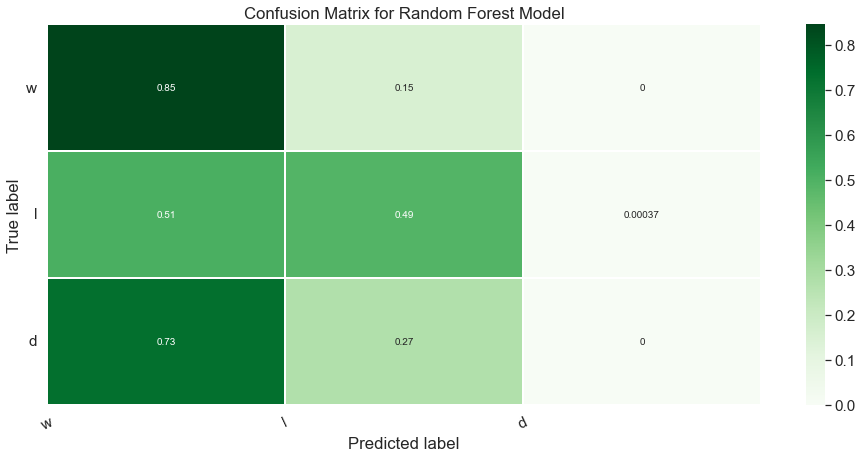

In [176]:

# Best forest
best_forest = grid_search.best_estimator_
print(best_forest.get_params)

# Assess scores of all forest models with mean scores on test set
grid_scores = grid_search.cv_results_
for mean_test, mean_train, params in zip(grid_scores['mean_test_score'], grid_scores['mean_train_score'], grid_scores['params']):
    print(mean_test, mean_train, params)

# Check confusion matrix of best forest
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
import seaborn as sns

y_train_pred = cross_val_predict(best_forest, X_train_prepared, y_train, cv=5)
labels = ['w','l','d'] #Define label order
conf_matrix = confusion_matrix(y_train, y_train_pred, labels=labels)
conf_matrix = conf_matrix.astype('float')/conf_matrix.sum(axis=1)[:, np.newaxis] # Convert to ratios

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
tick_marks = np.arange(len(labels))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, labels, rotation=25)
plt.yticks(tick_marks2, labels, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()


In [178]:
# Check feature importance for best forest
for name, score in zip(X_train.columns.values.tolist(), best_forest.feature_importances_):
    print(name, score*100,'%')

home_bool-1 11.145411188427682 %
result-1 3.4666741495053515 %
comb_xG 8.166902522297596 %
comb_xGA 3.9784889658662412 %
comb_npxG 8.026913285817919 %
comb_npxGA 4.418101726643066 %
comb_deep 19.968262362357372 %
comb_deep_allowed 2.734602064174506 %
comb_xpts 0.376256579683597 %
comb_wins 2.1960846375055505 %
comb_draws 6.800783095158951 %
comb_loses 15.761030746286684 %
comb_pts 1.3191825493590628 %
comb_npxGD 11.30131087100074 %
comb_ppda_ratio 0.11183258182301094 %
comb_oppda_ratio 0.118420595263089 %
